# Import libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense

In [3]:
stock = pd.read_csv('https://raw.githubusercontent.com/mwitiderrick/stockprice/master/NSE-TATAGLOBAL.csv', index_col = 0)

In [4]:
stock.head()

,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
Date,,,,,,,
2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914,7162.35
2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509,7999.55


In [5]:
stock.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2035 entries, 2018-09-28 to 2010-07-21
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Open                  2035 non-null   float64
 1   High                  2035 non-null   float64
 2   Low                   2035 non-null   float64
 3   Last                  2035 non-null   float64
 4   Close                 2035 non-null   float64
 5   Total Trade Quantity  2035 non-null   int64  
 6   Turnover (Lacs)       2035 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 127.2+ KB


In [6]:
stock.shape

(2035, 7)

In [7]:
stock.describe()

,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
count,2035.000000,2035.000000,2035.000000,2035.000000,2035.00000,2.035000e+03,2035.000000
mean,149.713735,151.992826,147.293931,149.474251,149.45027,2.335681e+06,3899.980565
std,48.664509,49.413109,47.931958,48.732570,48.71204,2.091778e+06,4570.767877
min,81.100000,82.800000,80.000000,81.000000,80.95000,3.961000e+04,37.040000
25%,120.025000,122.100000,118.300000,120.075000,120.05000,1.146444e+06,1427.460000
50%,141.500000,143.400000,139.600000,141.100000,141.25000,1.783456e+06,2512.030000
75%,157.175000,159.400000,155.150000,156.925000,156.90000,2.813594e+06,4539.015000
max,327.700000,328.750000,321.650000,325.950000,325.75000,2.919102e+07,55755.080000


## Check outliers

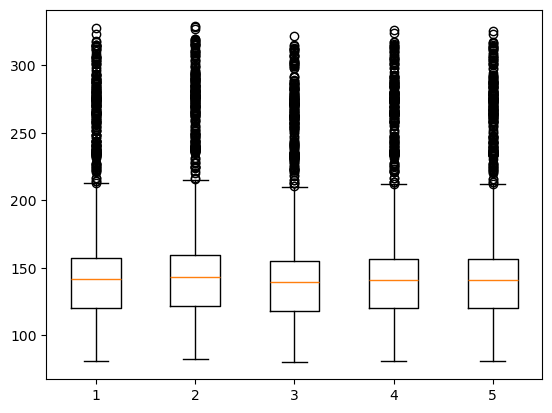

In [8]:
plt.boxplot(stock[['Open', 'High', 'Low', 'Last', 'Close']])
plt.show()

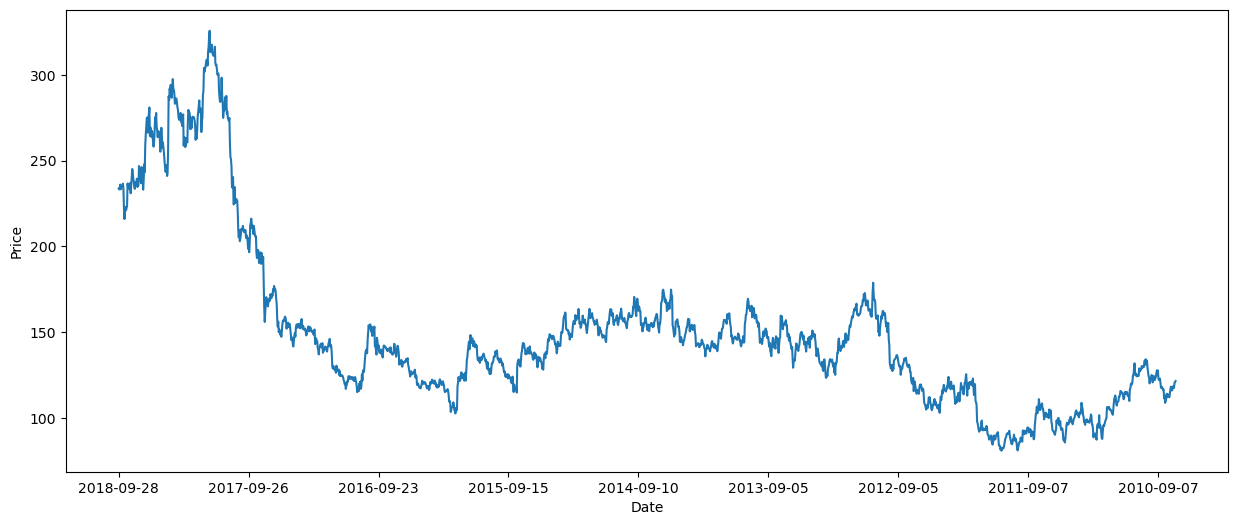

In [9]:
stock['Close'].plot(figsize = (15,6))
plt.ylabel('Price')
plt.show()

## Train Test Split

In [10]:
training_stock = stock.iloc[:int(len(stock)*0.75), ]
testing_stock = stock.iloc[int(len(stock)*0.75):, ]

In [11]:
training_stock.shape

(1526, 7)

In [12]:
testing_stock.shape

(509, 7)

In [13]:
training_stock.head()

,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
Date,,,,,,,
2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914,7162.35
2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509,7999.55


In [14]:
training_stock.iloc[:,4:5]

,Close
Date,
2018-09-28,233.75
2018-09-27,233.25
2018-09-26,234.25
2018-09-25,236.10
2018-09-24,233.30
...,...
2012-08-03,131.15
2012-08-02,130.05
2012-08-01,127.05


In [15]:
training_data = training_stock.iloc[:,4:5].values
training_data

array([[233.75],
       [233.25],
       [234.25],
       ...,
       [127.05],
       [127.  ],
       [122.65]])

In [16]:
training_data.shape

(1526, 1)

## Data Scaling

In [17]:
scaler=MinMaxScaler(feature_range=(0,1))
scaled_training_data = scaler.fit_transform(training_data)

In [18]:
scaled_training_data

array([[0.58762887],
       [0.58538772],
       [0.58987001],
       ...,
       [0.109368  ],
       [0.10914388],
       [0.0896459 ]])

## LSTM Implementation

In [19]:
x_train=[]
y_train=[]
for i in range(60,len(training_data)):
    x_train.append(scaled_training_data[i-60:i,0])
    y_train.append(scaled_training_data[i, 0])
x_train,y_train=np.array(x_train),np.array(y_train)

In [20]:
# Reshape to fit into LSTM
x_train=x_train.reshape(x_train.shape[0],x_train.shape[1],1)

In [21]:
#Initiate the Model
lstm=Sequential([
    LSTM(60,return_sequences=True,input_shape=(x_train.shape[1],1)),
    Dropout(0.3),
    LSTM(60,return_sequences=True),
    Dropout(0.3),
    LSTM(60,return_sequences=True),
    Dropout(0.3),
    LSTM(60,return_sequences=True),
    Dropout(0.3),
    LSTM(60,return_sequences=False),
    Dropout(0.3),
    Dense(1)
])

In [22]:
#Compile the Model
lstm.compile(optimizer='adam',loss='mean_squared_error')

In [23]:
# Fit the Model
lstm.fit(x_train,y_train,epochs=100,batch_size=64)

Epoch 1/100

23/23 [==============================] - 10s 94ms/step - loss: 0.0181
Epoch 2/100
23/23 [==============================] - 2s 87ms/step - loss: 0.0060
Epoch 3/100
23/23 [==============================] - 2s 85ms/step - loss: 0.0049
Epoch 4/100
23/23 [==============================] - 2s 84ms/step - loss: 0.0051
Epoch 5/100
23/23 [==============================] - 2s 83ms/step - loss: 0.0044
Epoch 6/100
23/23 [==============================] - 2s 85ms/step - loss: 0.0042
Epoch 7/100
23/23 [==============================] - 2s 86ms/step - loss: 0.0043
Epoch 8/100
23/23 [==============================] - 2s 86ms/step - loss: 0.0040
Epoch 9/100
23/23 [==============================] - 2s 83ms/step - loss: 0.0037
Epoch 10/100
23/23 [==============================] - 2s 84ms/step - loss: 0.0033
Epoch 11/100
23/23 [==============================] - 2s 84ms/step - loss: 0.0035
Epoch 12/100
23/23 [==============================] - 2s 85ms/step - loss: 0.0039
Epoch 13/100
23/23 [===

In [24]:
final_data =pd.concat((training_stock['Close'],testing_stock['Close']),axis=0)

In [25]:
inputs=final_data[len(final_data)-len(testing_stock)-60:].values
inputs=inputs.reshape(-1,1)
inputs=scaler.transform(inputs)

In [26]:
x_test=[]
for i in range(60,569):
    x_test.append(inputs[i-60:i, 0])
x_test=np.array(x_test)

In [27]:
x_test=x_test.reshape(x_test.shape[0],x_test.shape[1],1)

In [28]:
predicted_stock_price=lstm.predict(x_test)

16/16 [==============================] - 2s 20ms/step


In [29]:
predicted_stock_price=scaler.inverse_transform(predicted_stock_price)

In [30]:
testing_stock['Predicted']=predicted_stock_price

C:\Users\Gaurav.DESKTOP-IOPIP0E\AppData\Local\Temp\ipykernel_25436\3526848106.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_stock['Predicted']=predicted_stock_price


In [31]:
final_visualization=pd.concat([stock['Close'],testing_stock['Close'],testing_stock['Predicted']],axis=1)

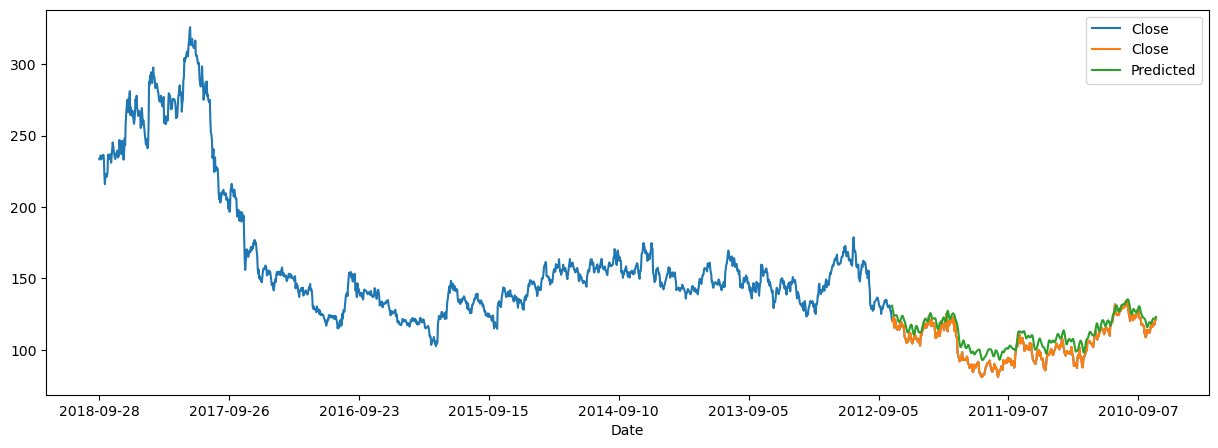

In [32]:
final_visualization.plot(figsize=(15,5))
final_visualization.columns=['Training Data','Testing Data','Predicted']

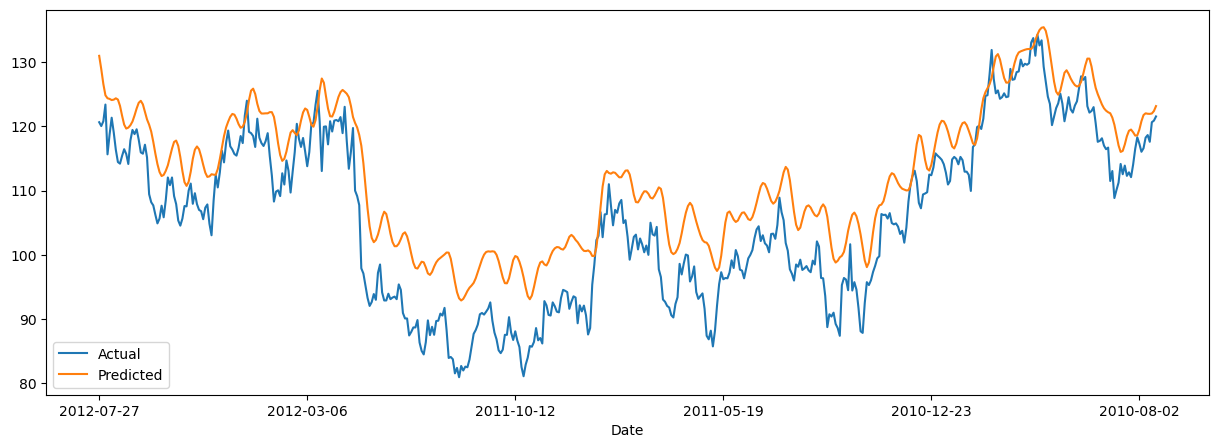

In [33]:
plt.figure(figsize=(15,5))
testing_stock['Close'].plot(label='Actual')
testing_stock['Predicted'].plot(label='Predicted')
plt.legend()
plt.show()

In [34]:
Actual=testing_stock['Close']
Predicted=testing_stock['Predicted']
Difference = Predicted - Actual

In [35]:
Dataframe=pd.DataFrame({'Actual':Actual,'Predicted':Predicted, 'Difference':Difference})
Dataframe

,Actual,Predicted,Difference
Date,,,
2012-07-27,120.65,130.984818,10.334818
2012-07-26,120.05,128.907974,8.857974
2012-07-25,120.80,126.597916,5.797916
2012-07-24,123.40,124.843315,1.443315
2012-07-23,115.65,124.380592,8.730592
...,...,...,...
2010-07-27,118.65,121.966454,3.316454
2010-07-26,117.60,121.949997,4.349997
2010-07-23,120.65,122.007294,1.357294
